In [3]:
%pip install -q ultralytics onnx
%pip install -q "openvino-dev>=2023.1.0"
%pip install -q gradio

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
from pathlib import Path

import openvino as ov
import torch
from PIL import Image, ImageDraw
from ultralytics import FastSAM
from ultralytics.models.fastsam import FastSAMPrompt

device = 'cpu'

model_name = 'FastSAM-x'
model = FastSAM(model_name)

# Run inference on an image
image_uri = 'https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg'
everything_results = model(image_uri, device=device, retina_masks=True, imgsz=1024, conf=0.4, iou=0.9)




Found https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg locally at coco_bike.jpg
image 1/1 /home/idavidyu/openvino_notebooks/notebooks/257-fast-segment-anything/coco_bike.jpg: 768x1024 56 objects, 714.0ms
Speed: 3.0ms preprocess, 714.0ms inference, 40.8ms postprocess per image at shape (1, 3, 768, 1024)


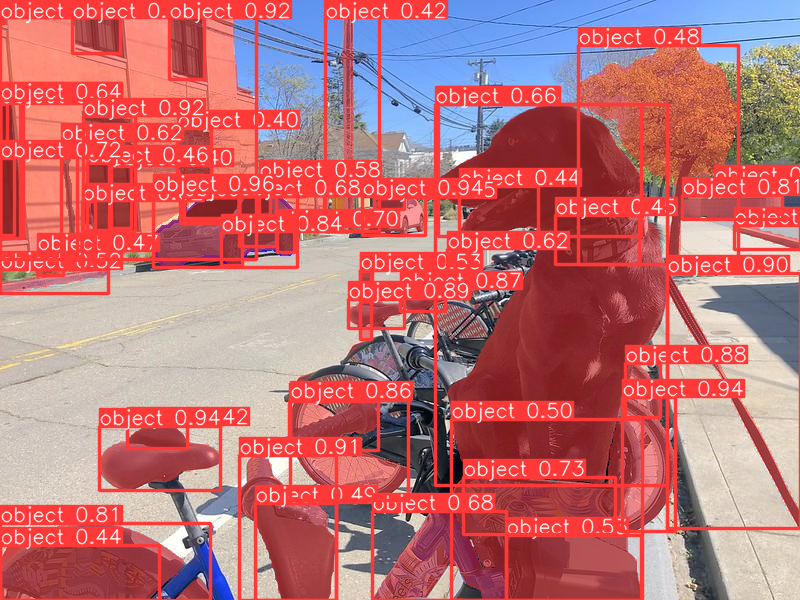

In [3]:
Image.fromarray(everything_results[0].plot()[..., ::-1])

In [4]:
# instance segmentation model
ov_model_path = Path(f'{model_name}_openvino_model/{model_name}.xml')
if not ov_model_path.exists():
    ov_model = model.export(format="openvino", dynamic=True, half=False)


In [5]:
class OVWrapper(torch.nn.Module):
    def __init__(self, ov_model, stride=32) -> None:
        super().__init__()
        self.model = ov.compile_model(ov_model)

        self.stride = stride
        self.pt = True
        self.fp16 = False
        self.names = {0: 'object'}

    def __call__(self, im, **_):
        result = self.model(im)
        return (torch.tensor(result[0]), torch.tensor(result[1]))

In [25]:
wrapped_model = OVWrapper(ov_model_path, model.predictor.model.stride)
model.predictor.model = wrapped_model

ov_results = model(image_uri, device=device, retina_masks=True, imgsz=640, conf=0.4, iou=0.9)


Found https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco_bike.jpg locally at coco_bike.jpg
image 1/1 /home/idavidyu/openvino_notebooks/notebooks/257-fast-segment-anything/coco_bike.jpg: 480x640 44 objects, 340.0ms
Speed: 1.9ms preprocess, 340.0ms inference, 32.9ms postprocess per image at shape (1, 3, 480, 640)


In [26]:
ov_results[0].masks.data[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

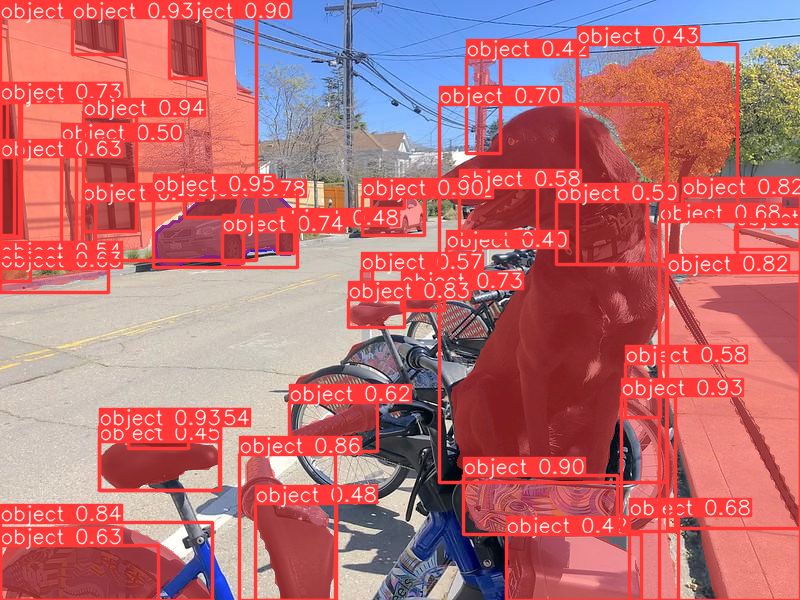

In [27]:
Image.fromarray(ov_results[0].plot()[..., ::-1])

In [9]:
# prompt_process = FastSAMPrompt(image_uri, ov_results, device='cpu')

# Everything prompt
# ann = prompt_process.everything_prompt()

# Bbox default shape [0,0,0,0] -> [x1,y1,x2,y2]
# ann = prompt_process.box_prompt(bbox=[200, 200, 300, 300])

# Text prompt
# ann = prompt_process.text_prompt(text='dog gogogo')

# Point prompt
# points default [[0,0]] [[x1,y1],[x2,y2]]
# point_label default [0] [1,0] 0:background, 1:foreground
# ann = prompt_process.point_prompt(points=[[200, 200]], pointlabel=[1])


# prompt_process.plot(annotations=ann, output='./')


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def fast_process(
    annotations,
    image,
    scale,
    better_quality=False,
    mask_random_color=True,
    bbox=None,
    use_retina=True,
    withContours=True,
):

    original_h = image.height
    original_w = image.width

    if better_quality:
        for i, mask in enumerate(annotations):
            mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8))
            annotations[i] = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_OPEN, np.ones((8, 8), np.uint8))
    # device is CPU

    inner_mask = fast_show_mask(
        annotations,
        plt.gca(),
        random_color=mask_random_color,
        bbox=bbox,
        retinamask=use_retina,
        target_height=original_h,
        target_width=original_w,
    )

    if withContours:
        contour_all = []
        temp = np.zeros((original_h, original_w, 1))
        for i, mask in enumerate(annotations):
            if type(mask) == dict:
                mask = mask['segmentation']
            annotation = mask.astype(np.uint8)
            if use_retina == False:
                annotation = cv2.resize(
                    annotation,
                    (original_w, original_h),
                    interpolation=cv2.INTER_NEAREST,
                )
            contours, _ = cv2.findContours(annotation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                contour_all.append(contour)
        cv2.drawContours(temp, contour_all, -1, (255, 255, 255), 2 // scale)
        color = np.array([0 / 255, 0 / 255, 255 / 255, 0.9])
        contour_mask = temp / 255 * color.reshape(1, 1, -1)

    image = image.convert('RGBA')
    overlay_inner = Image.fromarray((inner_mask * 255).astype(np.uint8), 'RGBA')
    image.paste(overlay_inner, (0, 0), overlay_inner)

    if withContours:
        overlay_contour = Image.fromarray((contour_mask * 255).astype(np.uint8), 'RGBA')
        image.paste(overlay_contour, (0, 0), overlay_contour)

    return image


# CPU post process
def fast_show_mask(
    annotation,
    ax,
    random_color=False,
    bbox=None,
    retinamask=True,
    target_height=960,
    target_width=960,
):
    mask_sum = annotation.shape[0]
    height = annotation.shape[1]
    weight = annotation.shape[2]
    # 
    areas = np.sum(annotation, axis=(1, 2))
    sorted_indices = np.argsort(areas)[::1]
    annotation = annotation[sorted_indices]

    index = (annotation != 0).argmax(axis=0)
    if random_color:
        color = np.random.random((mask_sum, 1, 1, 3))
    else:
        color = np.ones((mask_sum, 1, 1, 3)) * np.array([30 / 255, 144 / 255, 255 / 255])
    transparency = np.ones((mask_sum, 1, 1, 1)) * 0.6
    visual = np.concatenate([color, transparency], axis=-1)
    mask_image = np.expand_dims(annotation, -1) * visual

    mask = np.zeros((height, weight, 4))

    h_indices, w_indices = np.meshgrid(np.arange(height), np.arange(weight), indexing='ij')
    indices = (index[h_indices, w_indices], h_indices, w_indices, slice(None))

    mask[h_indices, w_indices, :] = mask_image[indices]
    if bbox is not None:
        x1, y1, x2, y2 = bbox
        ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='b', linewidth=1))

    if not retinamask:
        mask = cv2.resize(mask, (target_width, target_height), interpolation=cv2.INTER_NEAREST)

    return mask

def format_results(result, filter=0):
    annotations = []
    n = len(result.masks.data)
    for i in range(n):
        annotation = {}
        mask = result.masks.data[i] == 1.0

        if torch.sum(mask) < filter:
            continue
        annotation["id"] = i
        annotation["segmentation"] = mask.cpu().numpy()
        annotation["bbox"] = result.boxes.data[i]
        annotation["score"] = result.boxes.conf[i]
        annotation["area"] = annotation["segmentation"].sum()
        annotations.append(annotation)
    return annotations

def point_prompt(masks, points, point_label, target_height, target_width):  # numpy 处理
    h = masks[0]["segmentation"].shape[0]
    w = masks[0]["segmentation"].shape[1]
    if h != target_height or w != target_width:
        points = [
            [int(point[0] * w / target_width), int(point[1] * h / target_height)]
            for point in points
        ]
    onemask = np.zeros((h, w))
    masks = sorted(masks, key=lambda x: x['area'], reverse=True)
    for i, annotation in enumerate(masks):
        if type(annotation) == dict:
            mask = annotation['segmentation']
        else:
            mask = annotation
        for i, point in enumerate(points):
            if mask[point[1], point[0]] == 1 and point_label[i] == 1:
                onemask[mask] = 1
            if mask[point[1], point[0]] == 1 and point_label[i] == 0:
                onemask[mask] = 0
    onemask = onemask >= 1
    return onemask, 0


In [11]:
import gradio as gr

device = 'cpu'


def segment_everything(
    input,
    input_size=1024, 
    iou_threshold=0.7,
    conf_threshold=0.25,
    better_quality=True,
    withContours=True,
    use_retina=True,
    wider=False,
    mask_random_color=True,
):
    input_size = int(input_size)  # 确保 imgsz 是整数
    # Thanks for the suggestion by hysts in HuggingFace.
    w, h = input.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    input = input.resize((new_w, new_h))

    results = model(input,
                    device=device,
                    retina_masks=True,
                    iou=iou_threshold,
                    conf=conf_threshold,
                    imgsz=input_size,)

    annotations = np.array(results[0].masks.data)
    
    fig = fast_process(annotations=annotations,
                       image=input,
                       scale=(1024 // input_size),
                       better_quality=better_quality,
                       mask_random_color=mask_random_color,
                       bbox=None,
                       use_retina=use_retina,
                       withContours=withContours,)
    return fig

def segment_with_points(
    input,
    input_size=1024, 
    iou_threshold=0.7,
    conf_threshold=0.25,
    better_quality=False,
    withContours=True,
    use_retina=True,
    mask_random_color=True,
):
    global global_points
    global global_point_label
    
    input_size = int(input_size)  # 确保 imgsz 是整数
    # Thanks for the suggestion by hysts in HuggingFace.
    w, h = input.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    input = input.resize((new_w, new_h))
    
    results = model(input,
                    device=device,
                    retina_masks=True,
                    iou=iou_threshold,
                    conf=conf_threshold,
                    imgsz=input_size,)
    
    scaled_points = [[int(x * scale) for x in point] for point in global_points]
    
    results = format_results(results[0], 0)
    annotations, _ = point_prompt(results, scaled_points, global_point_label, new_h, new_w)
    annotations = np.array([annotations])

    fig = fast_process(annotations=annotations,
                       image=input,
                       scale=(1024 // input_size),
                       better_quality=better_quality,
                       mask_random_color=mask_random_color,
                       bbox=None,
                       use_retina=use_retina,
                       withContours=withContours,)

    global_points = []
    global_point_label = []
    return fig, None


def get_points_with_draw(image, label, evt: gr.SelectData):
    print('start')
    global global_points
    global global_point_label

    x, y = evt.index[0], evt.index[1]
    point_radius, point_color = 15, (0, 255, 0) if label == 'Add Mask' else (255, 0, 0)
    global_points.append([x, y])
    global_point_label.append(1 if label == 'Add Mask' else 0)
    
    print(x, y, label == 'Add Mask')
    
    draw = ImageDraw.Draw(image)
    draw.ellipse([(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)], fill=point_color)
    print('end')
    return image

examples = [[image_uri], ['https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/empty_road_mapillary.jpg'],
            ['https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/wall.jpg']]

default_example = examples[0]


cond_img_e = gr.Image(label="Input", value=default_example[0], type='pil')
cond_img_p = gr.Image(label="Input with points", value=default_example[0], type='pil')

segm_img_e = gr.Image(label="Segmented Image", interactive=False, type='pil')
segm_img_p = gr.Image(label="Segmented Image with points", interactive=False, type='pil')

global_points = []
global_point_label = []

input_size_slider = gr.components.Slider(minimum=512,
                                         maximum=1024,
                                         value=1024,
                                         step=64,
                                         label='Input size (px)',
                                         info='The model was trained on 1024')

with gr.Blocks(title='Fast SAM') as demo:
    with gr.Row():
        with gr.Column(scale=1):
            gr.Markdown("Fast Segment Anything")

    with gr.Tab("Everything mode"):
        # Images
        with gr.Row(variant="panel"):
            with gr.Column(scale=1):
                cond_img_e.render()

            with gr.Column(scale=1):
                segm_img_e.render()

        # Submit & Clear
        with gr.Row():
            with gr.Column():
                input_size_slider.render()

                with gr.Row():
                    contour_check = gr.Checkbox(value=True, label='withContours', info='draw the edges of the masks')

                    with gr.Column():
                        segment_btn_e = gr.Button("Segment Everything", variant='primary')
                        clear_btn_e = gr.Button("Clear", variant="secondary")

                gr.Markdown("Try some of the examples below ⬇️")
                gr.Examples(examples=examples,
                            inputs=[cond_img_e],
                            outputs=segm_img_e,
                            # fn=segment_everything,
                            cache_examples=False,
                            examples_per_page=4)

            with gr.Column():
                with gr.Accordion("Advanced options", open=False):
                    iou_threshold = gr.Slider(0.1, 0.9, 0.7, step=0.1, label='iou', info='iou threshold for filtering the annotations')
                    conf_threshold = gr.Slider(0.1, 0.9, 0.25, step=0.05, label='conf', info='object confidence threshold')
                    with gr.Row():
                        mor_check = gr.Checkbox(value=False, label='better_visual_quality', info='better quality using morphologyEx')
                        with gr.Column():
                            retina_check = gr.Checkbox(value=True, label='use_retina', info='draw high-resolution segmentation masks')


    segment_btn_e.click(segment_everything,
                        inputs=[
                            cond_img_e,
                            input_size_slider,
                            iou_threshold,
                            conf_threshold,
                            mor_check,
                            contour_check,
                            retina_check,
                        ],
                        outputs=segm_img_e)

    with gr.Tab("Points mode"):
        # Images
        with gr.Row(variant="panel"):
            with gr.Column(scale=1):
                cond_img_p.render()

            with gr.Column(scale=1):
                segm_img_p.render()
                
        # Submit & Clear
        with gr.Row():
            with gr.Column():
                with gr.Row():
                    add_or_remove = gr.Radio(["Add Mask", "Remove Area"], value="Add Mask", label="Point_label (foreground/background)")

                    with gr.Column():
                        segment_btn_p = gr.Button("Segment with points prompt", variant='primary')
                        clear_btn_p = gr.Button("Clear points", variant='secondary')

                gr.Markdown("Try some of the examples below ⬇️")
                gr.Examples(examples=examples,
                            inputs=[cond_img_p],
                            # outputs=segm_img_p,
                            # fn=segment_with_points,
                            # cache_examples=True,
                            examples_per_page=4)

            with gr.Column():
                pass
                # Description
                # gr.Markdown(description_p)


    def clear():
        return None, None
    
    def clear_text():
        return None, None, None

    clear_btn_e.click(clear, outputs=[cond_img_e, segm_img_e])
    clear_btn_p.click(clear, outputs=[cond_img_p, segm_img_p])

    cond_img_p.select(get_points_with_draw, [cond_img_p, add_or_remove], cond_img_p)
    segment_btn_p.click(segment_with_points,
                        inputs=[cond_img_p],
                        outputs=[segm_img_p, cond_img_p])
demo.queue()
demo.launch(share=False, debug=True)

Running on local URL:  http://127.0.0.1:7860


KeyboardInterrupt: 

In [15]:
object_points = []
background_points = []
bbox_points = []
last_image = default_example[0]
def select_point(img, point_type, evt: gr.SelectData):
    img = img.convert("RGBA")
    x, y = evt.index[0], evt.index[1]
    point_radius = np.round(max(img.size) / 100)
    if point_type == 'Object point':
        object_points.append((x, y))
        color = (30, 255, 30, 200)
    elif point_type == 'Background point':
        background_points.append((x, y))
        color = (255, 30, 30, 200)
    elif point_type == 'Bounding Box':
        bbox_points.append((x, y))
        color = (10, 10, 255, 255)
        if len(bbox_points) % 2 == 0:
            # Draw a rectangle if number of points is even
            new_img = Image.new('RGBA', img.size, (255, 255, 255, 0))
            _draw = ImageDraw.Draw(new_img)
            x0, y0, x1, y1 = *bbox_points[-2], *bbox_points[-1]
            x0, x1 = sorted([x0, x1])
            y0, y1 = sorted([y0, y1])
            _draw.rectangle((x0, y0, x1, y1), fill=(*color[:-1], 90))
            img = Image.alpha_composite(img, new_img)
    # Draw a point
    ImageDraw.Draw(img).ellipse(
        [(x - point_radius, y - point_radius), (x + point_radius, y + point_radius)],
        fill=color
    )
    return img

def save_last_picked_image(img):
    global last_image
    last_image = img
    return img

def clear_points():
    object_points = []
    background_points = []
    bbox_points = []
    return last_image, None

def segment(image,
    input_size=1024, 
    iou_threshold=0.7,
    conf_threshold=0.25,
    better_quality=True,
    withContours=True,
    use_retina=True,
    wider=False,
    mask_random_color=True,
):
    input_size = int(input_size)
    w, h = image.size
    scale = input_size / max(w, h)
    new_w = int(w * scale)
    new_h = int(h * scale)
    image = image.resize((new_w, new_h))

    results = model(image,
                    device='cpu',
                    retina_masks=use_retina,
                    iou=iou_threshold,
                    conf=conf_threshold,
                    imgsz=input_size,)

    # Calculate annotations
    annotations
    return fast_process(annotations=annotations,
                       image=image,
                       scale=(1024 // input_size),
                       better_quality=better_quality,
                       mask_random_color=mask_random_color,
                       bbox=None,
                       use_retina=use_retina,
                       withContours=withContours,)

with gr.Blocks(title='Fast SAM') as demo:
    with gr.Row(variant="panel"):
        original_img = gr.Image(label="Input", value=default_example[0], type='pil')
        segmented_img = gr.Image(label="Segmentation Map", type='pil')
    point_type = gr.Radio(['Object point', 'Background point', 'Bounding Box'],
             value='Object point', label='Pixel selector type')
    with gr.Row(variant="panel"):
        segment_button = gr.Button("Segment", variant='primary')
        clear_button = gr.Button("Clear points", variant='secondary')
    gr.Examples(examples, inputs=original_img, fn=save_last_picked_image, run_on_click=True, outputs=original_img)

    # Callbacks
    original_img.select(select_point,
                        inputs=[original_img, point_type],
                        outputs=original_img)
    clear_button.click(clear_points, outputs=[original_img, segmented_img])
    segment_button.click(segment, inputs=[original_img,], outputs=segmented_img)

demo.queue().launch(share=False, debug=True)

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.
